## Emergency Datahack, трек #2: предсказание роста максимального уровня воды на реке Лене в весенний период<a class="anchor" id="0-bullet">

* [1. Загрузка данных](#1-bullet)
* [2. Преобразование гидрологических данных](#2-bullet)
* [3. Преобразование метеорологических данных](#3-bullet)
* [4. Приведение метеоданных к единой временной детализации](#4-bullet)
* [5. Интерполяция метеоданных в точках гидропостов](#5-bullet)
* [6. Базовая модель](#6-bullet)

Сводка важных сообщений из этого ноутбука:

<div class="alert alert-block alert-success">
Внимание! Пары {station_id: std_sq}, на которые нормируются ошибки MSE для каждого из целевых гидропостов:
        <li>3019: 185.35707752426708,
        <li>3027: 1223.8071616577856,
        <li>3028: 1357.4062812989373,
        <li>3029: 1520.7730161870682,
        <li>3030: 1765.9217904996142,
        <li>3035: 765.3703832632036,
        <li>3041: 443.5766934006718,
        <li>3045: 579.1353554017562,
        <li>3050: 612.0471238561079,
        <li>3230: 516.6669876251401

Расчет метрики приведен в пункте 6.
</div>

<div class="alert alert-block alert-danger">
Внимание-2! <b>Нельзя использовать данные из будущего для предсказания прошлых событий</b> (так называемые лики). Иными словами, нельзя использовать данные, временной период для которых позднее, чем время наблюдения, целевую переменную для которого вы пытаетесь предсказать.
</div>

<div class="alert alert-block alert-info">
FYI. В тестовую выборку попали периоды из следующих лет:
<li>1989
<li>1993
<li>1997
<li>2001
<li>2003
<li>2004
<li>2005
<li>2012
<li>2013
</div>

In [5]:
from datetime import datetime
import json5 as json
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

from multiprocessing import Pool, cpu_count

# from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly,plot_cross_validation_metric
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'prophet'

In [1]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\gorba\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\gorba\\AppData\\Local\\Temp\\pip-install-240791gz\\fbprophet_0215fa61b9254bd48e64479e1458f7b8\\setup.py'"'"'; __file__='"'"'C:\\Users\\gorba\\AppData\\Local\\Temp\\pip-install-240791gz\\fbprophet_0215fa61b9254bd48e64479e1458f7b8\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\gorba\AppData\Local\Temp\pip-wheel-jntb3wnq'
       cwd: C:\Users\gorba\AppData\Local\Temp\pip-install-240791gz\fbprophet_0215fa61b9254bd48e64479e1458f7b8\
  Complete output (10 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  INFO:pystan:COMPILING THE C++ CODE FOR MODEL


  Running setup.py clean for fbprophet
Failed to build fbprophet
    Running setup.py install for fbprophet: started
    Running setup.py install for fbprophet: finished with status 'error'


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [7]:
import os# C:\Users\gorba\DataSciense\datahack
path = os.getcwd()

In [8]:
directory_hist = path + "\\track_2_package"
directory_extra = path + "\\2_track_cp1"

In [9]:
# directory_hist = '/home/common/emergency_datahack/data_processed/track_2/track_2_package/'
# directory_extra = '/home/common/emergency_datahack/data_processed/track_2/checkpoints/cp4/'

### 1. Загрузка данных<a class="anchor" id="1-bullet"></a>
[назад к оглавлению](#0-bullet)

В нашем распоряжении есть следующие данные:

**Исторические:**
- train.csv — ежедневные наблюдения на гидропостах;
- meteo_3hours.csv — наблюдения на метеостанциях через каждые 3 часа;
- meteo_1day.csv — ежедневные наблюдения на метеостанциях;
- meteo_1month.csv — значения метеопараметров за месяц;
- hydro_coord.csv — географическая привязка гидропостов;
- meteo_coord.csv — географические координаты метеостанций;
- reference_water_codes.csv — коды режимных групп с расшифровкой и группировкой;
- reference_horiz_visib.csv — коды дальности горизонтальной видимости с расшифровкой;
- ice_saw.csv — мероприятия по ослаблению прочности льда.

**Дополнительные исторические (в каждой дополнительной выдаче):**
- extra_train.csv
- extra_meteo_3hours.csv
- extra_meteo_1day.csv
- extra_meteo_1month.csv

**Для тестового периода (в каждой дополнительной выдаче):**
- test.csv
- forecast_meteo_3hours.csv

In [10]:
# выгрузим в DTYPES названия полей и соответствующие им типы данных

with open('dtypes.json', 'r') as f:
    DTYPES = json.load(f)

In [11]:
DTYPES

{'train': {'station_id': 'Int64',
  'date': 'string',
  'stage_avg': 'Int64',
  'stage_min': 'Int64',
  'stage_max': 'Int64',
  'temp': 'Float64',
  'water_code': 'string',
  'ice_thickness': 'Int64',
  'snow_height': 'Int64',
  'place': 'string',
  'discharge': 'Float64',
  'year': 'Int64',
  'month': 'Int64',
  'day': 'Int64',
  'delta_stage_max': 'Int64'},
 'meteo_3hours': {'station_id': 'Int64',
  'year_GMT': 'Int64',
  'month_GMT': 'Int64',
  'day_GMT': 'Int64',
  'synop_hour_GMT': 'Int64',
  'year_local': 'Int64',
  'month_local': 'Int64',
  'day_local': 'Int64',
  'synop_hour_local': 'Int64',
  'synop_hour_order_PDZV': 'Int64',
  'time_local': 'Int64',
  'timezone': 'Int64',
  'meteo_day_start_PDZV': 'Int64',
  'source_index': 'Int64',
  'horizontal_visibility': 'Int64',
  'horizontal_visibility_qual': 'Int64',
  'horizontal_visibility_qual_1': 'Int64',
  'cloud_amount_total': 'Int64',
  'cloud_amount_total_qual': 'Int64',
  'cloud_amount_low_level': 'Int64',
  'cloud_amount_low

In [12]:
custom_date_parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d')

train_hist = pd.read_csv(directory_hist + '\\train.csv',
                         dtype=DTYPES['train'],
                         parse_dates=['date'], date_parser=custom_date_parser)

In [13]:
# исторические данные

custom_date_parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d')

train_hist = pd.read_csv(directory_hist + '\\train.csv',
                         dtype=DTYPES['train'],
                         parse_dates=['date'], date_parser=custom_date_parser)

# meteo_3hours_hist = pd.read_csv(directory_hist + '\\meteo_3hours.csv',
#                                 dtype=DTYPES['meteo_3hours'],
#                                 parse_dates=['date_local'], date_parser=custom_date_parser)

meteo_1day_hist = pd.read_csv(directory_hist + '\\meteo_1day.csv',
                              dtype=DTYPES['meteo_1day'],
                              parse_dates=['date'], date_parser=custom_date_parser)

meteo_1month_hist = pd.read_csv(directory_hist + '\\meteo_1month.csv',
                                dtype=DTYPES['meteo_1month'],
                                parse_dates=['date'], date_parser=custom_date_parser)

hydro_coord = pd.read_csv(directory_hist + '\\hydro_coord.csv', dtype=DTYPES['hydro_coord'])
meteo_coord = pd.read_csv(directory_hist + '\\meteo_coord.csv', dtype=DTYPES['meteo_coord'])

reference_water_codes = pd.read_csv(directory_hist + '\\reference_water_codes.csv', dtype=DTYPES['reference_water_codes'])
reference_horiz_visib = pd.read_csv(directory_hist + '\\reference_horiz_visib.csv', dtype=DTYPES['reference_horiz_visib'])

ice_saw = pd.read_csv(directory_hist + '\\ice_saw.csv',
                      dtype=DTYPES['ice_saw'],
                      parse_dates=['date'], date_parser=custom_date_parser)

In [24]:
# дополнительные исторические данные

extra_train = pd.read_csv(directory_extra + '\\extra_train.csv',
                          dtype=DTYPES['train'],
                          parse_dates=['date'], date_parser=custom_date_parser)

extra_meteo_3hours = pd.read_csv(directory_extra + '\\extra_meteo_3hours.csv',
                                 dtype=DTYPES['meteo_3hours'],
                                 parse_dates=['date_local'], date_parser=custom_date_parser)

extra_meteo_1day = pd.read_csv(directory_extra + '\\extra_meteo_1day.csv',
                               dtype=DTYPES['meteo_1day'],
                               parse_dates=['date'], date_parser=custom_date_parser)

extra_meteo_1month = pd.read_csv(directory_extra + '\\extra_meteo_1month.csv',
                                 dtype=DTYPES['meteo_1month'],
                                 parse_dates=['date'], date_parser=custom_date_parser)

In [25]:
# данные на тестовый период

test = pd.read_csv(directory_extra + '\\test.csv',
                   dtype=DTYPES['test'],
                   parse_dates=['date'], date_parser=custom_date_parser)

forecast_meteo_3hours = pd.read_csv(directory_extra + '\\forecast_meteo_3hours.csv',
                                    dtype=DTYPES['meteo_3hours'],
                                    parse_dates=['date_local'], date_parser=custom_date_parser)

In [ ]:
train_hist

<div class="alert alert-block alert-warning">
Сейчас в датафреймах пропуски имеют значение pd.NA. Внимание, поведения pd.NA и np.NaN различаются! 
</div>

In [30]:
# объединим исторические и дополнительные данные

train = pd.concat([train_hist, extra_train])
# meteo_3hours = pd.concat([meteo_3hours_hist, extra_meteo_3hours])
meteo_1day = pd.concat([meteo_1day_hist, extra_meteo_1day])
meteo_1month = pd.concat([meteo_1month_hist, extra_meteo_1month])

### 2. Преобразование гидрологических данных<a class="anchor" id="2-bullet"></a>
[назад к оглавлению](#0-bullet)

In [31]:
# преобразуем water_code в список кодов режимных групп

def water_code_to_list(water_code):
    if isinstance(water_code, str):
        list_ = water_code.split(',')
        list_ = [i.strip() for i in list_ if i != '']
    else:
        list_ = []
    return list_


train['water_code'] = train['water_code'].apply(water_code_to_list)

In [32]:
# перейдем от списка режимных групп к dummy-переменным

values = list(train['water_code'].values)
lengths = [len(x) for x in values]

codes, uniques = pd.factorize(np.concatenate(values))
uniques = ['water_code_' + i for i in uniques]

n_rows, n_cols = len(values), len(uniques)

i = np.arange(n_rows).repeat(lengths)

dummies = pd.DataFrame(
    np.bincount(i * n_cols + codes, minlength=n_rows * n_cols).reshape(n_rows, n_cols),
    train.index, uniques
)

# код не имеет расшифровки в кодбуке — дропнем
dummies.drop(columns=['water_code_0'], inplace=True)

train = train.drop(columns='water_code').join(dummies)

In [33]:
train.columns

Index(['station_id', 'date', 'stage_avg', 'stage_min', 'stage_max', 'temp',
       'ice_thickness', 'snow_height', 'place', 'discharge', 'year', 'month',
       'day', 'delta_stage_max', 'water_code_16', 'water_code_23',
       'water_code_28', 'water_code_15', 'water_code_26', 'water_code_25',
       'water_code_9', 'water_code_29', 'water_code_1', 'water_code_4',
       'water_code_5', 'water_code_2', 'water_code_11', 'water_code_27',
       'water_code_8', 'water_code_46', 'water_code_18', 'water_code_47',
       'water_code_22', 'water_code_17', 'water_code_14', 'water_code_34',
       'water_code_12', 'water_code_3', 'water_code_42', 'water_code_60',
       'water_code_21', 'water_code_24', 'water_code_51', 'water_code_49',
       'water_code_48', 'water_code_10', 'water_code_6', 'water_code_41',
       'water_code_39', 'water_code_7', 'water_code_50', 'water_code_38',
       'water_code_13', 'water_code_36'],
      dtype='object')

### 3. Преобразование метеорологических данных<a class="anchor" id="3-bullet"></a>
[назад к оглавлению](#0-bullet)

In [34]:
# коды горизонтальной дальности видимости для мэппинга

map_horiz_visib = {}

for record in reference_horiz_visib.to_dict('records'):
    code = record['code']
    km = record['km']
    map_horiz_visib[code] = km

# внесем изменения в расшифровку кодов, чтобы в значениях получить только float

for key, value in map_horiz_visib.items():
    if value == '< 0.05':
        new_value = 0.025
    elif value == '< 0.1':
        new_value = 0.05
    elif value == '> 50':
        new_value = 75
    elif value == '> 70':
        new_value = 105
    else:
        new_value = float(value)
    map_horiz_visib[key] = new_value

In [35]:
def transform_meteo_3hours(df):
    df['horizontal_visibility'] = df['horizontal_visibility'].map(map_horiz_visib)

In [14]:
transform_meteo_3hours(meteo_3hours)

In [36]:
# константы отсутсвтия заменим на pd.NA

for col in ['snow_height',
            'temperature_20cm',
            'temperature_40cm',
            'temperature_80cm',
            'temperature_120cm',
            'temperature_160cm',
            'temperature_240cm',
            'temperature_320cm',
            'temperature_ks_5cm',
            'temperature_ks_10cm',
            'temperature_ks_15cm',
            'temperature_ks_20cm']:
    meteo_1day[col] = meteo_1day[col].replace(9999, pd.NA)

### 4. Приведение метеоданных к единой временной детализации<a class="anchor" id="4-bullet"></a>
[назад к оглавлению](#0-bullet)

В задаче требуется построить предиктивную модель, которая будет предсказывать *суточное* изменение максимального уровня воды. Поэтому убедимся, что все данные приведены к детализации до суток.

Для этого сагрегируем восьмисрочные наблюдения (вид агрегации — усреднение, суммирование и пр. — будут зависеть от смыслового содержания признака), а затем объединим агрегированные восьмисрочные, суточные и месячные данные. Поскольку в meteo_1month хранятся суммы метеопараметров за месяц, можно было бы дню приписать значение суммы, деленное на число дней в месяце. Однако, для матмоделирования это, скорее всего, непринципиально, поэтому преобразовывать месячные данные не будем.

In [37]:
# распределим признаки по спискам в зависимости от типа агрегации;
# на данном этапе не будем использовать коды качества признаков

to_group_by = [
    'station_id',
    'date_local'
]

to_average = [
    'horizontal_visibility',
    'cloud_amount_total',
    'cloud_base_altitude',
    'wind_direction',
    'wind_speed_aver',
    'soil_surface_temperature',
    'air_temperature',
    'air_temperature_wet_bulb',
    'water_vapour_partial_pressure',
    'relative_humidity',
    'vapour_pressure_deficit',
    'dew_point_temperature',
    'pressure',
    'pressure_sea_level',
    'barometric_tendency'
]

to_min = [
    'soil_surface_alco_temperature',
    'soil_surface_temperature_min_before',
    'air_temperature_min_alco_temperature',
    'air_temperature_min_before'
]

to_max = [
    'wind_speed_max',
    'soil_surface_temperature_max_before',
    'soil_surface_max_temperature',
    'air_temperature_max_before',
    'air_max_temperature'
]

to_most_frequent = [
    'cloud_form_high_level',
    'cloud_form_middle_level',
    'cloud_form_vertical_develop',
    'cloud_form_strat_stratocum',
    'cloud_form_strat_rain',
    'cloud_below_station',
    'soil_surface_condition',
    'weather_before',
    'weather',
    'air_temperature_wet_bulb_qual_1',
    'barometric_tendency_characteristic'
]

to_sum = ['precipitation']

In [38]:
# соответствие полей и применяемых к ним функций

fun_by_columns = {}

for col in to_average:
    fun_by_columns[col] = 'mean'

for col in to_min:
    fun_by_columns[col] = 'min'

for col in to_max:
    fun_by_columns[col] = 'max'

for col in to_most_frequent:
    fun_by_columns[col] = lambda x: pd.Series.mode(x, dropna=False).values[0]

for col in to_sum:
    fun_by_columns[col] = 'sum'

In [39]:
def aggregate_meteo_3hours(df):
    df_3hours_agg = df.groupby(to_group_by, as_index=False).agg(fun_by_columns)
    df_3hours_agg.rename(columns={'date_local': 'date'}, inplace=True)
    return df_3hours_agg


def join_by_day(df_3hours_agg, df_1day, df_1month):
    df_joined = pd.merge(df_3hours_agg, df_1day,
                         on=['station_id', 'date'],
                         how='outer')
    
    cols = list(df_1month.columns)
    cols.remove('data_qual')
    cols.remove('day')
    
    df_joined = pd.merge(df_joined, df_1month[cols],
                         on=['station_id', 'date'],
                         how='outer')
    
    return df_joined

In [19]:
# %%time

# # на 15 минут

# aggregated_meteo_3hours = aggregate_meteo_3hours(meteo_3hours)
# joined_meteo = join_by_day(aggregated_meteo_3hours, meteo_1day, meteo_1month)

In [40]:
# joined_meteo.to_csv('joined_meteo.csv', index=False)
joined_meteo = pd.read_csv('/home/y.khabibullina/github/cpur/projects/emergency/joined_meteo.csv',
                           parse_dates=['date'], date_parser=custom_date_parser)

FileNotFoundError: [Errno 2] No such file or directory: '/home/y.khabibullina/github/cpur/projects/emergency/joined_meteo.csv'

In [21]:
joined_meteo.head(2)

,station_id,date,horizontal_visibility,cloud_amount_total,cloud_base_altitude,wind_direction,wind_speed_aver,soil_surface_temperature,air_temperature,air_temperature_wet_bulb,water_vapour_partial_pressure,relative_humidity,vapour_pressure_deficit,dew_point_temperature,pressure,pressure_sea_level,barometric_tendency,soil_surface_alco_temperature,soil_surface_temperature_min_before,air_temperature_min_alco_temperature,air_temperature_min_before,wind_speed_max,soil_surface_temperature_max_before,soil_surface_max_temperature,air_temperature_max_before,air_max_temperature,cloud_form_high_level,cloud_form_middle_level,cloud_form_vertical_develop,cloud_form_strat_stratocum,cloud_form_strat_rain,cloud_below_station,soil_surface_condition,weather_before,weather,air_temperature_wet_bulb_qual_1,barometric_tendency_characteristic,precipitation,year_x,month_x,day,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_20cm_qual,temperature_40cm,temperature_40cm_qual,temperature_80cm,temperature_80cm_qual,temperature_120cm,temperature_120cm_qual,temperature_160cm,temperature_160cm_qual,temperature_240cm,temperature_240cm_qual,temperature_320cm,temperature_320cm_qual,temperature_ks_5cm,temperature_ks_5cm_qual,temperature_ks_10cm,temperature_ks_10cm_qual,temperature_ks_15cm,temperature_ks_15cm_qual,temperature_ks_20cm,temperature_ks_20cm_qual,year_y,month_y,precipitation_observed,precipitation_corrected,precipitation_corrected_liquid,precipitation_corrected_mixed,precipitation_corrected_solid,sunshine_hours
0,24538,1985-01-01,NaN,5.25,NaN,274.375,1.625,-43.3250,-43.4375,NaN,0.10000,76.125,0.03375,-45.8375,1009.6625,1030.7000,1.625,-44.5,-45.0,-45.1,-45.3,4.0,-42.2,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,2.0,0.0,2.0,0.0,1985.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985.0,1.0,3.8,5.7,0.0,0.0,5.7,NaN
1,24538,1985-01-02,NaN,0.00,NaN,315.000,1.750,-47.8625,-47.4875,NaN,0.06375,74.500,0.02000,-50.1125,1021.7750,1043.4625,1.150,-48.8,-49.2,-48.8,-48.8,5.0,-47.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2.0,0.0,2.0,0.0,1985.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5. Интерполяция метеоданных в точках гидропостов<a class="anchor" id="5-bullet"></a>
[назад к оглавлению](#0-bullet)

**Интерполяция для исторических данных**

In [41]:
meteo_features = [
    'horizontal_visibility', 'cloud_amount_total', 'cloud_base_altitude', 'wind_direction',
    'wind_speed_aver', 'soil_surface_temperature', 'air_temperature', 'air_temperature_wet_bulb',
    'water_vapour_partial_pressure', 'relative_humidity', 'vapour_pressure_deficit', 'dew_point_temperature',
    'pressure', 'pressure_sea_level', 'barometric_tendency', 'soil_surface_alco_temperature',
    'soil_surface_temperature_min_before', 'air_temperature_min_alco_temperature', 'air_temperature_min_before',
    'wind_speed_max', 'soil_surface_temperature_max_before', 'soil_surface_max_temperature',
    'air_temperature_max_before', 'air_max_temperature', 'cloud_form_high_level', 'cloud_form_middle_level',
    'cloud_form_vertical_develop', 'cloud_form_strat_stratocum', 'cloud_form_strat_rain',
    'cloud_below_station', 'soil_surface_condition', 'weather_before', 'weather',
    'air_temperature_wet_bulb_qual_1', 'barometric_tendency_characteristic', 'precipitation',
    'snow_coverage_near_station', 'snow_coverage_route', 'ice_crust_route', 'snow_height_aver',
    'snow_height_max', 'snow_height_min', 'snow_density_aver', 'ice_crust_aver', 'snow_saturated_thickness',
    'water_thickness', 'water_in_snow', 'water_total', 'snow_coverage_charact', 'snow_charact',
    'snow_height', 'snow_coverage_station', 'temperature_20cm', 'temperature_40cm', 'temperature_80cm',
    'temperature_120cm', 'temperature_160cm', 'temperature_240cm', 'temperature_320cm', 'temperature_ks_5cm',
    'temperature_ks_10cm', 'temperature_ks_15cm', 'temperature_ks_20cm', 'precipitation_observed',
    'precipitation_corrected', 'precipitation_corrected_liquid', 'precipitation_corrected_mixed',
    'precipitation_corrected_solid', 'sunshine_hours'
]

In [23]:
# %%time

# # вышло на полчаса

# hydro_station_ids = list(hydro_coord['station_id'].values)
# hydro_longitudes = list(hydro_coord['lon'].values)
# hydro_latitudes = list(hydro_coord['lat'].values)


# def meteo_interpolation_by_date(date, meteo_data):
#     station_ids = meteo_data['station_id'].unique()
#     condition = meteo_coord['station_id'].isin(station_ids)
    
#     longitudes = list(meteo_coord.loc[condition, 'lon'].values)
#     latitudes = list(meteo_coord.loc[condition, 'lat'].values)
    
#     d = {}
    
#     for feature in meteo_features:
#         values = meteo_data[feature].fillna(meteo_data[feature].mean())

#         if len(values.unique()) == 1:
#             interpolated_values = np.full(hydro_coord.shape[0], values.values[0])
#         elif values.max() == values.min():
#             interpolated_values = np.full(hydro_coord.shape[0], values.mean())
#         else:
#             OK = OrdinaryKriging(longitudes,
#                                  latitudes,
#                                  values,
#                                  variogram_model='spherical',
#                                  coordinates_type='geographic')
            
#             interpolated_values, variance = OK.execute('points',
#                                                        hydro_longitudes,
#                                                        hydro_latitudes,
#                                                        backend='C',
#                                                        n_closest_points=3)
        
#         d[feature] = pd.Series(interpolated_values, index=hydro_station_ids)
    
#     df = pd.DataFrame(d, index=hydro_station_ids, columns=meteo_features)
#     df['date'] = date
    
#     return df.rename_axis('station_id').set_index('date', append=True)


# def daily_meteo_wrapper(args):
#     return meteo_interpolation_by_date(*args)

            
# with Pool(cpu_count() - 1) as p:
#     r = p.map(daily_meteo_wrapper, [(date, meteo_data) for date, meteo_data in joined_meteo.groupby('date')])
#     interpolated_meteo = pd.concat(r)
#     interpolated_meteo.to_csv('interpolated_meteo.csv')

### 6. Базовая модель<a class="anchor" id="6-bullet"></a>
[назад к оглавлению](#0-bullet)

**Метрика**: микровзвешенное значение среднеквадратичной ошибки MSE, нормированное на квадрат среднеквадратичного отклонения по целевым гидропостам.

<div class="alert alert-block alert-success">
Внимание: в STATION_COEFFS из ячейки ниже хранятся пары {station_id: std_sq}, на которые нормируются ошибки MSE.
</div>

In [42]:
# расчет метрики

# квадраты стандартных отклонений по гидропостам
STATION_COEFFS = {
        3019: 185.35707752426708,
        3027: 1223.8071616577856,
        3028: 1357.4062812989373,
        3029: 1520.7730161870682,
        3030: 1765.9217904996142,
        3035: 765.3703832632036,
        3041: 443.5766934006718,
        3045: 579.1353554017562,
        3050: 612.0471238561079,
        3230: 516.6669876251401
}

def rowwise_nse(row): 
    station_id = row.station_id
    station_coeff = STATION_COEFFS[station_id]
    
    actual = row['delta_stage_max_actual']
    predicted = row['delta_stage_max_predicted']
    return np.divide(np.square(np.subtract(predicted, actual)),
            station_coeff)

def score(actual_df, predicted_df):
    merged = pd.merge(
        left=predicted_df,
        right=actual_df,
        how='right',
        on=['date', 'station_id'],
        suffixes=('_predicted', '_actual'),
    )

    merged.delta_stage_max_predicted.fillna(0, inplace=True)
    merged['error'] = merged.apply(rowwise_nse, axis=1)
    merged.dropna(inplace=True)
    if len(merged) != len(actual_df):
        return 'length of predicted df does not match actual df'
    else:
        score = np.divide(merged['error'].sum(), len(merged))
        return score

In [43]:
STATION_COEFFS.keys()

dict_keys([3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3050, 3230])

In [44]:
train_years = list(set(train['year'].unique()) - set(test['year'].unique()))
cutoffs = pd.to_datetime([ datetime.datetime.strptime(str(year) + "-W16" + '-1', "%Y-W%W-%w") for year in train_years if year > train_years[:1][0]])

In [45]:
test = test[['station_id', 'date']]
test.columns = ['station','ds']
test['coef'] = test['station'].apply(lambda x: STATION_COEFFS[x])
test.head()

<ipython-input-45-fe001f83cfa4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['coef'] = test['station'].apply(lambda x: STATION_COEFFS[x])


,station,ds,coef
0,3019,1993-04-21,185.357078
1,3019,1993-04-22,185.357078
2,3019,1993-04-23,185.357078
3,3019,1993-04-24,185.357078
4,3019,1993-04-25,185.357078


In [46]:
data = train[['date', 'station_id', 'delta_stage_max']].copy()
data = data[data['station_id'].isin(STATION_COEFFS.keys())]
data = data.fillna(0)
data.columns = ['ds', 'station', 'y']
data = data.astype({'y': 'int', 'station': 'int'})
data.sort_values(['ds', 'station'],inplace=True)
data['coef'] = data['station'].apply(lambda x: STATION_COEFFS[x])


val = data[data['ds'] >= cutoffs[-1:][0]].reset_index(drop=True)
data = data[data['ds'] < cutoffs[-1:][0]]

### Обучим модель на трейне

<div class="alert alert-block alert-danger">
Внимание-2: <b>нельзя использовать данные из будущего для предсказания прошлых событий</b> (так называемые лики). Иными словами, нельзя использовать данные, временной период для которых позднее, чем время наблюдения, целевую переменную для которого вы пытаетесь предсказать.
</div>

P.S. Prophet() в будущее не заглядывает, молодец.

In [47]:
m = Prophet()
m.add_regressor('coef')
m.fit(data)

NameError: name 'Prophet' is not defined

In [30]:
df_cv = cross_validation(m, horizon='7 days', cutoffs=cutoffs[:-1])

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,13.092536,3.618361,2.413441,2.832382,1.704991,1.000000
1,2 days,35.484649,5.956899,2.874503,2.015032,1.557030,0.991632
2,3 days,2200.102262,46.905248,7.596205,1.699222,1.534214,0.987448
3,4 days,408.899105,20.221254,4.781596,2.243804,1.434910,0.983264
4,5 days,1374.804771,37.078360,6.589942,1.763682,1.368933,0.979079
5,6 days,1127.461842,33.577699,7.214461,1.730214,1.285301,0.979079
6,7 days,340.374243,18.449234,6.160093,1.704886,1.305275,0.987448


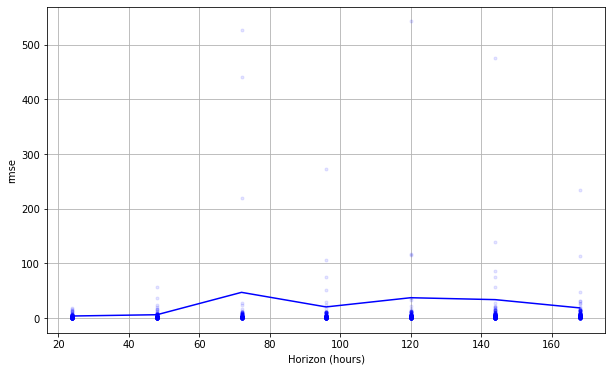

In [31]:
display(performance_metrics(df_cv))
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [32]:
val['y_pred'] = m.predict(val[['ds', 'station', 'coef']])['yhat']

In [33]:
val.head()

,ds,station,y,coef,y_pred
0,2019-04-22,3019,-1,185.357078,2.398145
1,2019-04-22,3027,1,1223.807162,2.468076
2,2019-04-22,3028,0,1357.406281,2.477072
3,2019-04-22,3029,0,1520.773016,2.488074
4,2019-04-22,3030,-1,1765.921790,2.504582


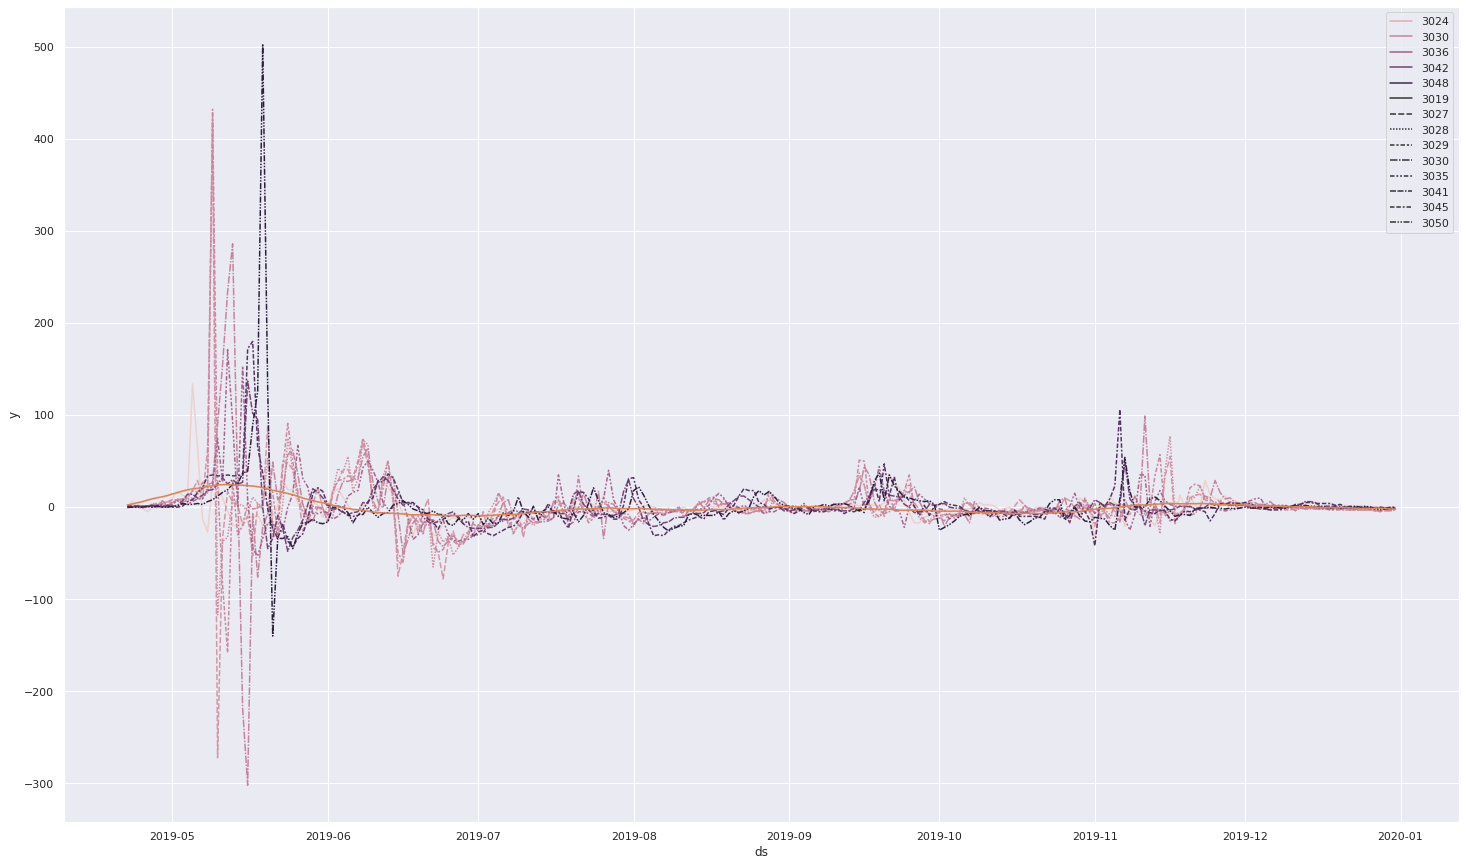

In [34]:
sns.set(rc={'figure.figsize':(25,15)})
sns.lineplot(data=val,x='ds', y='y',hue='station', style="station")
sns.lineplot(data=val,x='ds', y='y_pred');

### Проверим на валидационной выборке скор

In [35]:
print('rmse',mean_squared_error(val['y'],val['y_pred'],squared=False))
print('cmse',score(val.rename({'ds':'date','y':'delta_stage_max','station':'station_id'},axis=1),val.rename({'ds':'date','y_pred':'delta_stage_max','station':'station_id'},axis=1)))

rmse 28.839754568283347
cmse 0.9327150352852744


### Предскажем тестовую выборку и сохраним результат в файл для отправки сабмита

In [36]:
test['delta_stage_max'] = m.predict(test)['yhat']

In [37]:
test.columns = ['station_id', 'date', 'coef', 'delta_stage_max']

In [41]:
test['year'] = test['date'].dt.year
test['day'] = test['date'].dt.dayofyear

In [42]:
test.columns 

Index(['station_id', 'date', 'coef', 'delta_stage_max', 'year', 'day'], dtype='object')

In [44]:
test[['station_id', 'date', 'delta_stage_max', 'year', 'day']].to_csv('submit.csv')